# Experiment 013

In this experiment, we'll add random noise as an additional input to the Tetris emulator and see if it allows us to threshold the model output and still get believable, stochastic results.

In [1]:
import os
from pathlib import Path
import shutil
import datetime

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

In [2]:
class RecordingDataset(Dataset):
    def __init__(self, path: str):
        self.path = path
        if not os.path.exists(path):
            raise FileNotFoundError()
        with os.scandir(self.path) as it:
            entry: os.DirEntry = next(iter(it))
            _, self.ext = os.path.splitext(entry.name)
            self.highest_index = max((int(Path(file.path).stem) for file in it), default=-1)

    def __len__(self):
        return self.highest_index + 1

    def __getitem__(self, idx):
        file = os.path.join(self.path, f"{idx}{self.ext}")
        if not os.path.exists(file):
            raise IndexError()
        boards = np.load(file)
        x = torch.tensor(boards[-2]) # Ignore all boards except the last two
        y = torch.tensor(boards[-1], dtype=torch.long)
        return x, y
        

In [14]:
train_dataset = RecordingDataset(os.path.join("data", "tetris_emulator", "train"))
test_dataset = RecordingDataset(os.path.join("data", "tetris_emulator", "test"))
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

x, y = next(iter(train_dataloader))
print(x.shape, x.dtype)
print(y.shape, y.dtype)

torch.Size([4, 22, 10]) torch.int32
torch.Size([4, 22, 10]) torch.int64


In [15]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [36]:
class TetrisModel(nn.Module):
    """Predicts the next state of the cells.

    Inputs:
        x: Tensor of int32 of shape (batch_size, height, width). height = 22 and width = 10 are the dimensions of the game
           board. The entries should be 0 for empty cells and 1 for blocks.
        z: Tensor of float32 of shape (batch_size,). Random noise, which this model discards.
    
    Returns: Tensor of float32 of shape (batch_size, height, width), logits for the new cells. Probabilities close to 0 (negative logits)
             correspond to empty cells, and probabilities close to 1 (positive logits) correspond to blocks.
    """

    def __init__(self):
        super().__init__()
        self.loc = nn.Sequential(
            nn.Conv2d(2, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.glob = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(160, 10)
        )
        self.head = nn.Sequential(
            nn.Conv2d(26, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 2, 1),
            nn.LogSoftmax()
        )

    def forward(self, x, z):
        batch_size, height, width = x.shape
        
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1

        x = self.loc(x)

        x_glob = self.glob(x)
        x_glob = x_glob[:, :, None, None] # Expand dims
        x_glob = x_glob.repeat(1, 1, height, width) # Upscale to image size
        x = torch.cat((x, x_glob), dim=1)

        logits = self.head(x)
        return logits

In [65]:
class ModelWithRandomness(nn.Module):
    def __init__(self):
        super().__init__()
        self.loc = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.glob = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(160, 10)
        )
        self.head = nn.Sequential(
            nn.Conv2d(26, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 2, 1),
            nn.LogSoftmax()
        )

    def forward(self, x, z):
        batch_size, height, width = x.shape
        
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1

        z = z[:, None, None, None] # Expand dims to match x
        z = z.repeat(1, 1, height, width) # Upscale to image size
        x = torch.cat((x, z), dim=1)

        x = self.loc(x)

        x_glob = self.glob(x)
        x_glob = x_glob[:, :, None, None] # Expand dims
        x_glob = x_glob.repeat(1, 1, height, width) # Upscale to image size
        x = torch.cat((x, x_glob), dim=1)

        logits = self.head(x)
        return logits

In [66]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for model_class in [TetrisModel, ModelWithRandomness]:
    print(f"{model_class.__name__} has {count_parameters(model_class())} parameters.")

TetrisModel has 12828 parameters.
ModelWithRandomness has 12972 parameters.


In [67]:
model = ModelWithRandomness().to(device)

with torch.no_grad():
    X, y = next(iter(train_dataloader))
    z = torch.rand(batch_size)
    logits = model(X, z)[0]
    preds = torch.exp(logits)
    print(f"Predicted states: {preds}")

Predicted states: tensor([[[0.3112, 0.4302, 0.3874, 0.3541, 0.3541, 0.3541, 0.3541, 0.3655,
          0.3859, 0.4142],
         [0.2824, 0.4075, 0.3468, 0.3324, 0.3324, 0.3324, 0.3324, 0.3311,
          0.3320, 0.4735],
         [0.2813, 0.4611, 0.3815, 0.4337, 0.4337, 0.4337, 0.4337, 0.4239,
          0.4651, 0.4286],
         [0.2441, 0.4674, 0.3870, 0.4244, 0.4244, 0.4244, 0.4244, 0.4631,
          0.4360, 0.4361],
         [0.2441, 0.4674, 0.3870, 0.4244, 0.4244, 0.4244, 0.4244, 0.4631,
          0.4360, 0.4361],
         [0.2441, 0.4674, 0.3870, 0.4244, 0.4244, 0.4244, 0.4244, 0.4631,
          0.4360, 0.4361],
         [0.2441, 0.4674, 0.3870, 0.4244, 0.4244, 0.4244, 0.4244, 0.4631,
          0.4360, 0.4361],
         [0.2441, 0.4674, 0.3870, 0.4244, 0.4244, 0.4244, 0.4244, 0.4631,
          0.4360, 0.4361],
         [0.2441, 0.4674, 0.3870, 0.4244, 0.4244, 0.4244, 0.4244, 0.4631,
          0.4360, 0.4361],
         [0.2293, 0.4477, 0.4055, 0.4012, 0.4058, 0.3811, 0.4254, 0.4631,

In [190]:
import random

NUM_SPAWN_TYPES = 7

def get_spawn_type(y):
    if (y[1, :] == 0).all():
        return 0 # I
    if y[0, 3] == 1:
        if y[1, 3] == 1:
            return 1 # J
        else:
            if y[0, 5] == 1:
                return 2 # T
            else:
                return 3 # Z
    else:
        if y[1, 3] == 1:
            if y[0, 4] == 1:
                return 4 # S
            else:
                return 5 # L
        else:
            return 6 # O


def get_explanatory_randomness(X, y, use_oracle, onehot):
    """Given a batch of training examples X, returns a batch of random numbers that explain the block spawn type."""
    batch_size, height, width = X.shape

    # Allocate output tensor
    z_shape = (batch_size, NUM_SPAWN_TYPES) if onehot else (batch_size,)
    z = torch.zeros(z_shape)

    # Identify block spawns
    spawns = (X[:, 0, :] == 0).all(-1) & (y[:, 0, :] == 1).any(-1)

    # For each example, set randomness based on block spawn or at random
    for i in range(batch_size):
        spawn_type = get_spawn_type(y[i]) if (spawns[i] and use_oracle) else random.randrange(NUM_SPAWN_TYPES)
        if onehot:
            z[i, spawn_type] = 1.0
        else:
            z[i] = (z[i] + spawn_type) / 7.0
    
    return z

In [195]:
def train_loop(dataloader, model, loss_fn, optimizer, use_oracle, onehot):
    model.train()

    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        z = get_explanatory_randomness(X, y, use_oracle, onehot)
        pred = model(X, z)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test_loop(split_name, dataloader, model, loss_fn, use_oracle, onehot):
    model.eval()

    epoch_loss = 0.0
    board_accuracy = 0.0
    spawn_recall = 0.0
    num_spawns = 0.0
    spawn_precision = 0.0
    num_predicted_spawns = 0.0

    num_batches = len(dataloader)
    with torch.no_grad():
        for X, y in dataloader:
            z = get_explanatory_randomness(X, y, use_oracle, onehot)
            pred = model(X, z)
            epoch_loss += loss_fn(pred, y).item()
            classes = torch.argmax(pred, dim=1)
            board_accuracy += (classes == y).all(-1).all(-1).type(torch.float).mean().item()

            actual_spawns = (X[:, 0, :] == 0).all(-1) & (y[:, 0, :] == 1).any(-1)
            predicted_spawns = (classes[:, 0, :] == 1).any(-1)
            num_true_positives = (actual_spawns & predicted_spawns).type(torch.float).sum().item()
            spawn_recall += num_true_positives
            num_spawns += actual_spawns.type(torch.float).sum().item()
            spawn_precision += num_true_positives
            num_predicted_spawns += predicted_spawns.type(torch.float).sum().item()

    epoch_loss /= num_batches
    board_accuracy /= num_batches
    spawn_recall /= num_spawns
    spawn_precision = np.nan if num_predicted_spawns == 0.0 else spawn_precision / num_predicted_spawns
    
    return {
        "loss": epoch_loss,
        "acc_board": board_accuracy,
        "Spawn recall": spawn_recall,
        "Spawn precision": spawn_precision
    }

In [85]:
def find_interesting_examples(dataset):
    for x, y in dataset:
        # In our case, "interesting" currently means block spawns
        if (x[0] == 0).all() & (y[1] == 1).any():
            yield x, y

In [86]:
def render_prediction(x, pred, y):
    """Renders an example and prediction into a single-image array.
    
    Inputs:
        x: Tensor of shape (height, width), the model input.
        pred: Tensor of shape (height, width), the model prediction.
        y: Tensor of shape (height, width), the target.
    """
    assert len(x.shape) == 2
    assert x.shape == pred.shape
    assert x.shape == y.shape
    height, width = x.shape
    with torch.no_grad():
        separator = torch.ones(height, 1, dtype=x.dtype)
        return torch.cat((x, separator, pred, separator, y), dim=-1)

In [192]:
import itertools

def train(model, learning_rate=1e-1, epochs=100, use_oracle=False, onehot=False):
    loss_fn = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    log_dir = os.path.join("runs", "experiment_013")
    log_subdir = os.path.join(log_dir, f'{model.__class__.__name__}_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}')
    tb = SummaryWriter(log_subdir)

    train_examples = list(itertools.islice(find_interesting_examples(train_dataset), 3))
    test_examples = list(itertools.islice(find_interesting_examples(test_dataset), 3))

    print(f"Training model {model.__class__.__name__}...")
    for t in range(epochs):
        train_loop(train_dataloader, model, loss_fn, optimizer, use_oracle, onehot)
        train_metrics = test_loop("Train", train_dataloader, model, loss_fn, use_oracle, onehot)
        test_metrics = test_loop("Test", test_dataloader, model, loss_fn, use_oracle, onehot)
        tb.add_scalar("Loss/train", train_metrics["loss"], t)
        tb.add_scalar("Board accuracy/train", train_metrics["acc_board"], t)
        tb.add_scalar("Spawn recall/train", train_metrics["Spawn recall"], t)
        tb.add_scalar("Spawn precision/train", train_metrics["Spawn precision"], t)
        tb.add_scalar("Loss/test", test_metrics["loss"], t)
        tb.add_scalar("Board accuracy/test", test_metrics["acc_board"], t)
        tb.add_scalar("Spawn recall/test", test_metrics["Spawn recall"], t)
        tb.add_scalar("Spawn precision/test", test_metrics["Spawn precision"], t)
        for name, weight in model.named_parameters():
            tb.add_histogram(f"Weights/{name}", weight, t)
            tb.add_histogram(f"Gradients/{name}", weight.grad, t)
        with torch.no_grad():
            for i, (x, y) in enumerate(train_examples):
                z = get_explanatory_randomness(x.unsqueeze(0), y.unsqueeze(0), use_oracle, onehot)
                pred = model(x.unsqueeze(0), z).squeeze(0).argmax(dim=0)
                img = render_prediction(x, pred, y)
                tb.add_image(f"Predictions/train/{i}", img, t, dataformats="HW")
            for i, (x, y) in enumerate(test_examples):
                z = get_explanatory_randomness(x.unsqueeze(0), y.unsqueeze(0), use_oracle, onehot)
                pred = model(x.unsqueeze(0), z).squeeze(0).argmax(dim=0)
                img = render_prediction(x, pred, y)
                tb.add_image(f"Predictions/test/{i}", img, t, dataformats="HW")

    tb.close()
    print("Done!")

    return {
        "train_accuracy": train_metrics["acc_board"],
        "train_spawn_recall": train_metrics["Spawn recall"],
        "test_accuracy": test_metrics["acc_board"],
        "test_spawn_recall": test_metrics["Spawn recall"]
    }

In [193]:
from scipy.stats import ttest_ind

def train_and_compare_architectures(model_classes, repeats=6, use_oracle=False, onehot=False):
    architectures = [{"class": model_class} for model_class in model_classes]

    for a in architectures:
        a["train_accuracy"] = np.zeros(repeats)
        a["train_spawn_recall"] = np.zeros(repeats)
        a["test_accuracy"] = np.zeros(repeats)
        a["test_spawn_recall"] = np.zeros(repeats)

    for repeat in range(repeats):
        for architecture in architectures:
            model = architecture["class"]().to(device)
            repeat_results = train(model, use_oracle=use_oracle, onehot=onehot)
            architecture["train_accuracy"][repeat] = repeat_results["train_accuracy"]
            architecture["train_spawn_recall"][repeat] = repeat_results["train_spawn_recall"]
            architecture["test_accuracy"][repeat] = repeat_results["test_accuracy"]
            architecture["test_spawn_recall"][repeat] = repeat_results["test_spawn_recall"]
        
    print(f"Results:")
    for architecture in architectures:
        print(f"Class: {architecture['class'].__name__}")
        print(f"  Train accuracy mean {architecture['train_accuracy'].mean():.5f}, std {architecture['train_accuracy'].std():.5f}")
        print(f"  Test accuracy mean {architecture['test_accuracy'].mean():.5f}, std {architecture['test_accuracy'].std():.5f}")
        print(f"  Train spawn recall mean {architecture['train_spawn_recall'].mean():.5f}, std {architecture['train_spawn_recall'].std():.5f}")
        print(f"  Test spawn recall mean {architecture['test_spawn_recall'].mean():.5f}, std {architecture['test_spawn_recall'].std():.5f}")
        print()

    for architecture in architectures[1:]:
        baseline = architectures[0]
        print(f"Performing t-tests of {architecture['class'].__name__} against {baseline['class'].__name__}")
        accuracy_ttest = ttest_ind(baseline["test_accuracy"], architecture["test_accuracy"], equal_var=False)
        spawn_recall_ttest = ttest_ind(baseline["test_spawn_recall"], architecture["test_spawn_recall"], equal_var=False)
        print("Accuracy t-test results:")
        print(accuracy_ttest)
        print("Spawn recall t-test results:")
        print(spawn_recall_ttest)
        print()

In [73]:
train_and_compare_architectures([TetrisModel, ModelWithRandomness])

Training model ModelWithRandomness...
Done!
Training model TetrisModel...
Done!
Training model ModelWithRandomness...
Done!
Training model TetrisModel...
Done!
Training model ModelWithRandomness...
Done!
Training model TetrisModel...
Done!
Training model ModelWithRandomness...
Done!
Training model TetrisModel...
Done!
Training model ModelWithRandomness...
Done!
Training model TetrisModel...
Done!
Training model ModelWithRandomness...
Done!
Training model TetrisModel...
Done!
Results:
Class: ModelWithRandomness
  Train accuracy mean 0.94180, std 0.00071
  Test accuracy mean 0.91439, std 0.00169
  Train spawn recall mean 0.47333, std 0.14543
  Test spawn recall mean 0.47083, std 0.16293

Class: TetrisModel
  Train accuracy mean 0.94180, std 0.00042
  Test accuracy mean 0.91439, std 0.00169
  Train spawn recall mean 0.50000, std 0.11764
  Test spawn recall mean 0.46250, std 0.09100

Performing t-tests of TetrisModel against ModelWithRandomness
Accuracy t-test results:
Ttest_indResult(stat

It looks like the random input isn't helping by itself. The model still learns to predict the most common type of block spawn, and the training curves for the two model architectures look very similar.

Let's assess the best-case scenario: let's modify the random numbers so that they perfectly explain the block spawn type, and see if that benefits the model. If even this gives no benefit, then it's evidence that the model is underfitting.

# Best-case scenario: block spawn type oracle

In [82]:
train_and_compare_architectures([TetrisModel, ModelWithRandomness], use_oracle=True)

Training model ModelWithRandomness...


c:\Projects\game_emulation\venv\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Done!
Training model TetrisModel...
Done!
Training model ModelWithRandomness...
Done!
Training model TetrisModel...
Done!
Training model ModelWithRandomness...
Done!
Training model TetrisModel...
Done!
Training model ModelWithRandomness...
Done!
Training model TetrisModel...
Done!
Training model ModelWithRandomness...
Done!
Training model TetrisModel...
Done!
Training model ModelWithRandomness...
Done!
Training model TetrisModel...
Done!
Results:
Class: ModelWithRandomness
  Train accuracy mean 0.94208, std 0.00039
  Test accuracy mean 0.91667, std 0.00107
  Train spawn recall mean 0.40133, std 0.03984
  Test spawn recall mean 0.43750, std 0.11434

Class: TetrisModel
  Train accuracy mean 0.94104, std 0.00185
  Test accuracy mean 0.91364, std 0.00186
  Train spawn recall mean 0.47600, std 0.08845
  Test spawn recall mean 0.45833, std 0.07169

Performing t-tests of TetrisModel against ModelWithRandomness
Accuracy t-test results:
Ttest_indResult(statistic=3.1622776601682827, pvalue=0.013

The model seems not to benefit from having a block spawn type oracle, so maybe the model is just underfitting and needs more capacity.

# Bigger models

In [91]:
class WiderLocalModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.loc = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.glob = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(160, 10)
        )
        self.head = nn.Sequential(
            nn.Conv2d(42, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 2, 1),
            nn.LogSoftmax()
        )

    def forward(self, x, z):
        batch_size, height, width = x.shape
        
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1

        z = z[:, None, None, None] # Expand dims to match x
        z = z.repeat(1, 1, height, width) # Upscale to image size
        x = torch.cat((x, z), dim=1)

        x = self.loc(x)

        x_glob = self.glob(x)
        x_glob = x_glob[:, :, None, None] # Expand dims
        x_glob = x_glob.repeat(1, 1, height, width) # Upscale to image size
        x = torch.cat((x, x_glob), dim=1)

        logits = self.head(x)
        return logits


model = WiderLocalModel().to(device)

with torch.no_grad():
    X, y = next(iter(train_dataloader))
    z = torch.rand(batch_size)
    logits = model(X, z)[0]
    preds = torch.exp(logits)
    print(f"Predicted states: {preds}")

Predicted states: tensor([[[0.3696, 0.4127, 0.4992, 0.4408, 0.4408, 0.4408, 0.4408, 0.3562,
          0.4209, 0.1969],
         [0.4434, 0.2622, 0.3944, 0.3677, 0.3677, 0.3677, 0.3677, 0.3279,
          0.4091, 0.1607],
         [0.4093, 0.3593, 0.4029, 0.4253, 0.4253, 0.4253, 0.4253, 0.3938,
          0.3846, 0.1297],
         [0.4099, 0.3028, 0.4368, 0.4307, 0.4307, 0.4307, 0.4307, 0.3549,
          0.3598, 0.1235],
         [0.4099, 0.3028, 0.4368, 0.4307, 0.4307, 0.4307, 0.4307, 0.3549,
          0.3598, 0.1235],
         [0.4099, 0.3028, 0.4368, 0.4307, 0.4307, 0.4307, 0.4307, 0.3549,
          0.3598, 0.1235],
         [0.4099, 0.3028, 0.4368, 0.4307, 0.4307, 0.4307, 0.4307, 0.3549,
          0.3598, 0.1235],
         [0.4099, 0.3028, 0.4368, 0.4307, 0.4307, 0.4307, 0.4307, 0.3549,
          0.3598, 0.1235],
         [0.4099, 0.3028, 0.4368, 0.4307, 0.4307, 0.4307, 0.4307, 0.3549,
          0.3598, 0.1235],
         [0.4099, 0.3028, 0.4368, 0.4307, 0.4307, 0.4307, 0.4307, 0.3549,

c:\Projects\game_emulation\venv\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [92]:
class WiderGlobalModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.loc = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.glob = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(320, 16)
        )
        self.head = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 2, 1),
            nn.LogSoftmax()
        )

    def forward(self, x, z):
        batch_size, height, width = x.shape
        
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1

        z = z[:, None, None, None] # Expand dims to match x
        z = z.repeat(1, 1, height, width) # Upscale to image size
        x = torch.cat((x, z), dim=1)

        x = self.loc(x)

        x_glob = self.glob(x)
        x_glob = x_glob[:, :, None, None] # Expand dims
        x_glob = x_glob.repeat(1, 1, height, width) # Upscale to image size
        x = torch.cat((x, x_glob), dim=1)

        logits = self.head(x)
        return logits


model = WiderGlobalModel().to(device)

with torch.no_grad():
    X, y = next(iter(train_dataloader))
    z = torch.rand(batch_size)
    logits = model(X, z)[0]
    preds = torch.exp(logits)
    print(f"Predicted states: {preds}")

Predicted states: tensor([[[0.6459, 0.6785, 0.7665, 0.7721, 0.7721, 0.7721, 0.7721, 0.7578,
          0.7437, 0.7193],
         [0.6656, 0.5422, 0.6360, 0.6231, 0.6231, 0.6231, 0.6231, 0.6361,
          0.5276, 0.5421],
         [0.6955, 0.6783, 0.6351, 0.6747, 0.6747, 0.6747, 0.6747, 0.7097,
          0.6246, 0.6556],
         [0.6940, 0.6009, 0.6206, 0.6541, 0.6541, 0.6541, 0.6541, 0.6743,
          0.6102, 0.6148],
         [0.6940, 0.6009, 0.6206, 0.6541, 0.6541, 0.6541, 0.6541, 0.6743,
          0.6102, 0.6148],
         [0.6940, 0.5980, 0.6386, 0.6479, 0.6904, 0.6681, 0.6444, 0.6731,
          0.6115, 0.6148],
         [0.6940, 0.5893, 0.5861, 0.6496, 0.7078, 0.6757, 0.5940, 0.6518,
          0.6168, 0.6148],
         [0.6940, 0.5664, 0.6089, 0.6975, 0.7255, 0.7657, 0.7240, 0.6692,
          0.6181, 0.6148],
         [0.6940, 0.5520, 0.6364, 0.6712, 0.7689, 0.7510, 0.6297, 0.6686,
          0.6207, 0.6148],
         [0.6940, 0.5699, 0.5990, 0.5448, 0.6299, 0.6832, 0.5221, 0.5761,

In [94]:
class WiderAllModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.loc = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.glob = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(320, 16)
        )
        self.head = nn.Sequential(
            nn.Conv2d(48, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 2, 1),
            nn.LogSoftmax()
        )

    def forward(self, x, z):
        batch_size, height, width = x.shape
        
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1

        z = z[:, None, None, None] # Expand dims to match x
        z = z.repeat(1, 1, height, width) # Upscale to image size
        x = torch.cat((x, z), dim=1)

        x = self.loc(x)

        x_glob = self.glob(x)
        x_glob = x_glob[:, :, None, None] # Expand dims
        x_glob = x_glob.repeat(1, 1, height, width) # Upscale to image size
        x = torch.cat((x, x_glob), dim=1)

        logits = self.head(x)
        return logits


model = WiderAllModel().to(device)

with torch.no_grad():
    X, y = next(iter(train_dataloader))
    z = torch.rand(batch_size)
    logits = model(X, z)[0]
    preds = torch.exp(logits)
    print(f"Predicted states: {preds}")

Predicted states: tensor([[[0.4579, 0.3360, 0.3301, 0.3039, 0.3039, 0.3039, 0.3039, 0.3534,
          0.4539, 0.4306],
         [0.4724, 0.2551, 0.2851, 0.3083, 0.3083, 0.3083, 0.3083, 0.3686,
          0.3679, 0.3786],
         [0.5247, 0.4068, 0.4367, 0.4651, 0.4651, 0.4651, 0.4651, 0.4939,
          0.3566, 0.3731],
         [0.5135, 0.3682, 0.3923, 0.3959, 0.3959, 0.3959, 0.3959, 0.4511,
          0.3917, 0.4191],
         [0.5135, 0.3682, 0.3923, 0.3959, 0.3959, 0.3959, 0.3959, 0.4511,
          0.3917, 0.4191],
         [0.5135, 0.3682, 0.3923, 0.3959, 0.3959, 0.3959, 0.3959, 0.4511,
          0.3917, 0.4191],
         [0.5135, 0.3682, 0.3923, 0.3959, 0.3959, 0.3959, 0.3959, 0.4511,
          0.3917, 0.4191],
         [0.5135, 0.3682, 0.3680, 0.3684, 0.4245, 0.3663, 0.3380, 0.4771,
          0.3891, 0.4191],
         [0.5157, 0.3545, 0.3313, 0.3100, 0.3870, 0.3262, 0.3408, 0.3974,
          0.3681, 0.4191],
         [0.5062, 0.3688, 0.4031, 0.2242, 0.3412, 0.3250, 0.4798, 0.5298,

c:\Projects\game_emulation\venv\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [96]:
class SimplifiedModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 4, kernel_size=3, padding=0),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
        )
        self.mix = nn.Sequential(
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
        )
        self.dec = nn.Sequential(
            nn.Linear(32, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=(4, 16, 4)),
            nn.ConvTranspose2d(4, 8, kernel_size=3, padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, kernel_size=3, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 2, kernel_size=3, padding=1),
            nn.LogSoftmax(),
        )

    def forward(self, x, z):
        batch_size, height, width = x.shape
        
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1

        z = z[:, None, None, None] # Expand dims to match x
        z = z.repeat(1, 1, height, width) # Upscale to image size
        x = torch.cat((x, z), dim=1)

        x = self.enc(x)
        x = self.mix(x)
        logits = self.dec(x)

        return logits


model = SimplifiedModel().to(device)

with torch.no_grad():
    X, y = next(iter(train_dataloader))
    z = torch.rand(batch_size)
    logits = model(X, z)[0]
    preds = torch.exp(logits)
    print(f"Predicted states: {preds}")

Predicted states: tensor([[[0.4666, 0.6014, 0.4254, 0.6629, 0.6043, 0.6783, 0.5354, 0.4090,
          0.4796, 0.4462],
         [0.5597, 0.6315, 0.5367, 0.4924, 0.8108, 0.8416, 0.6102, 0.5939,
          0.6079, 0.6184],
         [0.6034, 0.7628, 0.7845, 0.7994, 0.7042, 0.9159, 0.7694, 0.6277,
          0.6216, 0.6239],
         [0.6809, 0.8678, 0.8648, 0.8835, 0.5875, 0.3678, 0.8281, 0.8083,
          0.6021, 0.4855],
         [0.7806, 0.9695, 0.7345, 0.6606, 0.8868, 0.2829, 0.6101, 0.8705,
          0.6033, 0.4708],
         [0.6210, 0.7642, 0.5345, 0.6443, 0.9824, 0.9222, 0.7318, 0.5394,
          0.5356, 0.4825],
         [0.7142, 0.5969, 0.8389, 0.3936, 0.7534, 0.5363, 0.6992, 0.6516,
          0.5784, 0.6197],
         [0.8356, 0.9787, 0.5524, 0.9807, 0.8627, 0.6114, 0.6474, 0.2980,
          0.5976, 0.6479],
         [0.6194, 0.7868, 0.6864, 0.8630, 0.5132, 0.8959, 0.9864, 0.7140,
          0.8057, 0.5543],
         [0.4168, 0.7128, 0.8716, 0.7688, 0.8695, 0.8920, 0.6729, 0.3380,

c:\Projects\game_emulation\venv\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [98]:
class SimplifiedModelWithRandomnessLater(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_x = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 4, kernel_size=3, padding=0),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
        )
        self.enc_z = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
        )
        self.mix = nn.Sequential(
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
        )
        self.dec = nn.Sequential(
            nn.Linear(32, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=(4, 16, 4)),
            nn.ConvTranspose2d(4, 8, kernel_size=3, padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, kernel_size=3, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 2, kernel_size=3, padding=1),
            nn.LogSoftmax(),
        )

    def forward(self, x, z):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1

        s = self.enc_x(x)

        z = z[:, None] # Expand dims to match x
        v = self.enc_z(z)
        s = torch.cat((s, v), dim=1)

        s = self.mix(s)
        logits = self.dec(s)

        return logits


model = SimplifiedModelWithRandomnessLater().to(device)

with torch.no_grad():
    X, y = next(iter(train_dataloader))
    z = torch.rand(batch_size)
    logits = model(X, z)[0]
    preds = torch.exp(logits)
    print(f"Predicted states: {preds}")

Predicted states: tensor([[[0.5253, 0.5938, 0.6525, 0.8623, 0.7962, 0.9134, 0.8037, 0.7639,
          0.6708, 0.5605],
         [0.5933, 0.8008, 0.6870, 0.7128, 0.8552, 0.7973, 0.8335, 0.7914,
          0.7639, 0.5898],
         [0.5776, 0.7346, 0.8057, 0.8515, 0.3866, 0.0689, 0.2169, 0.6137,
          0.4699, 0.5636],
         [0.5891, 0.7054, 0.4541, 0.3314, 0.9460, 0.7289, 0.9162, 0.5052,
          0.8747, 0.4521],
         [0.7491, 0.6850, 0.7335, 0.8721, 0.1090, 0.4391, 0.3388, 0.6621,
          0.7372, 0.5803],
         [0.6698, 0.6273, 0.7377, 0.6579, 0.5504, 0.5643, 0.4946, 0.5593,
          0.7364, 0.6567],
         [0.4680, 0.5701, 0.8932, 0.8235, 0.9161, 0.3213, 0.6590, 0.8200,
          0.4780, 0.5782],
         [0.6772, 0.7321, 0.7645, 0.9581, 0.3134, 0.9361, 0.5085, 0.8340,
          0.8086, 0.3898],
         [0.6662, 0.6978, 0.9796, 0.5574, 0.8998, 0.7225, 0.1592, 0.8208,
          0.5472, 0.4778],
         [0.6726, 0.6655, 0.6492, 0.9727, 0.7041, 0.7858, 0.7881, 0.9168,

c:\Projects\game_emulation\venv\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [99]:
for model_class in [TetrisModel, WiderLocalModel, WiderGlobalModel, WiderAllModel, SimplifiedModel, SimplifiedModelWithRandomnessLater]:
    print(f"{model_class.__name__} has {count_parameters(model_class())} parameters.")

TetrisModel has 12828 parameters.
WiderLocalModel has 25020 parameters.
WiderGlobalModel has 26674 parameters.
WiderAllModel has 48018 parameters.
SimplifiedModel has 26830 parameters.
SimplifiedModelWithRandomnessLater has 28830 parameters.


In [101]:
train_and_compare_architectures([TetrisModel, WiderLocalModel, WiderGlobalModel, WiderAllModel, SimplifiedModel, SimplifiedModelWithRandomnessLater], use_oracle=True, repeats=2)

Training model TetrisModel...


c:\Projects\game_emulation\venv\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Done!
Training model WiderLocalModel...
Done!
Training model WiderGlobalModel...
Done!
Training model WiderAllModel...
Done!
Training model SimplifiedModel...
Done!
Training model SimplifiedModelWithRandomnessLater...
Done!
Training model TetrisModel...
Done!
Training model WiderLocalModel...
Done!
Training model WiderGlobalModel...
Done!
Training model WiderAllModel...
Done!
Training model SimplifiedModel...
Done!
Training model SimplifiedModelWithRandomnessLater...
Done!
Results:
Class: TetrisModel
  Train accuracy mean 0.93141, std 0.01020
  Test accuracy mean 0.89773, std 0.01818
  Train spawn recall mean 0.72000, std 0.27200
  Test spawn recall mean 0.73750, std 0.26250

Class: WiderLocalModel
  Train accuracy mean 0.94274, std 0.00000
  Test accuracy mean 0.91705, std 0.00114
  Train spawn recall mean 0.44400, std 0.02000
  Test spawn recall mean 0.45000, std 0.02500

Class: WiderGlobalModel
  Train accuracy mean 0.94246, std 0.00028
  Test accuracy mean 0.91591, std 0.00000
  Tr

C:\Users\akubi\AppData\Local\Temp\ipykernel_10248\476966591.py:33: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  accuracy_ttest = ttest_ind(baseline["test_accuracy"], architecture["test_accuracy"], equal_var=False)


All the larger local-global based models (`WiderLocalModel`, `WiderGlobalModel` and `WiderAllModel`) have performance comparable to the baseline `TetrisModel`. In terms of loss and board accuracy, they are only marginally better. In terms of spawn recall, they are actually worse, even on the training set. This suggests that the models are not making use of the explanatory randomness at all. Maybe there is a bug in the explanatory randomness computation, or maybe the information needs to be provided to the models in another form, for example by one-hot encoding the block spawn type.

The "simplified" models (`SimplifiedModel` and `SimplifiedModelWithRandomnessLater`) struggle to learn anywhere near as fast as the local-global based models. The loss decreases very slowly and occasionally has huge spikes. By the end of 100 epochs, the models don't even learn enough to have a board accuracy reliably over 1%. The slow convergence of these models may be due to the aggressive bottleneck that the input `X` goes through to ensure the number of features is small. This is corroborated by the logged predictions, which seem to oscillate between different local structures between training epochs without much attention to detail. We could try to ameliorate this by increasing the number of features in the `mix` module. This can be achieved by increasing the number of filters in the `enc_x` module before it, or by reducing the amount of downscaling that happens in the `enc_x` module.

The `SimplifiedModelWithRandomnessLater` model has more frequent loss spikes than `SimplifiedModel`, which might be because of the lack of batch normalization after the second linear layer in the `enc_z` module. 

# Checking the explanatory randomness calculation

Index: 673
Block spawn type: 2


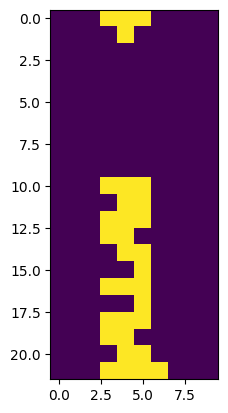

In [164]:
# Test spawn type calculation

import random

is_block_spawn = False
while not is_block_spawn:
    idx = random.randrange(len(train_dataset))
    x, y = train_dataset[idx]
    is_block_spawn = (x[0, :] == 0).all(-1) & (y[0, :] == 1).any(-1)
print(f"Index: {idx}")
print(f"Block spawn type: {get_spawn_type(y)}")
plt.imshow(x)
plt.imshow(y)

Looks like this works correctly. The block spawn types are `0: I, 1: J, 2: T, 3: Z, 4: S, 5: L, 6: O`.

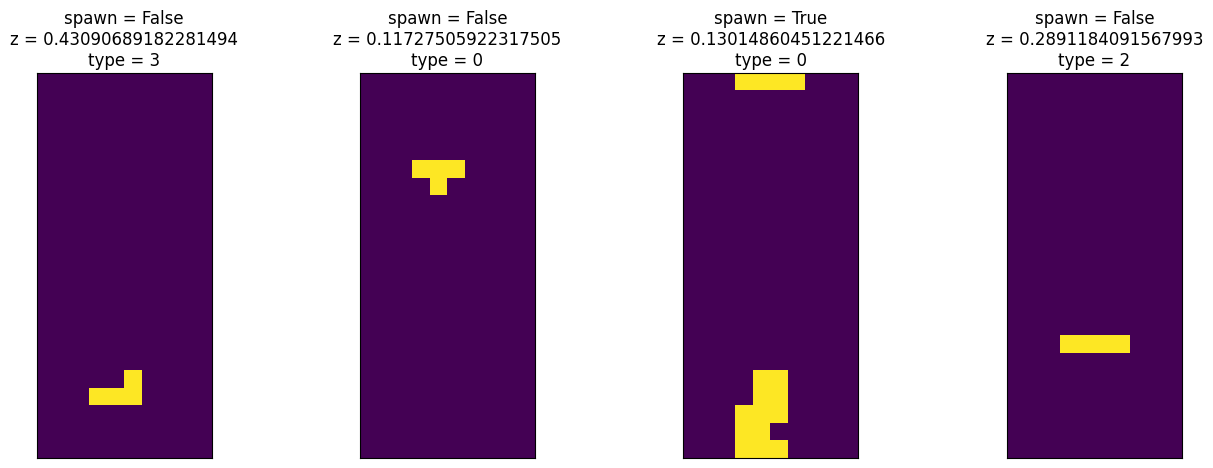

In [186]:
# Test explanatory randomness calculation

import math

def get_num_rows_cols(batch_size):
    return int(math.ceil(batch_size / 4.0)), 4

for X, y in train_dataloader:
    spawns = (X[:, 0, :] == 0).all(-1) & (y[:, 0, :] == 1).any(-1)
    if spawns.any():
        break
nrows, ncols = get_num_rows_cols(X.shape[0])
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 5*nrows))
z = get_explanatory_randomness(X, y)
spawn_types = (7.0 * z).type(torch.int)
for i in range(X.shape[0]):
    ax = axs.flat[i]
    ax.set_title(f"spawn = {spawns[i]}\nz = {z[i]}\ntype = {spawn_types[i]}")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.imshow(y[i])

plt.show()

Looks like the explanatory randomness is being calculated correctly. So why do the models not learn from it?

# One-hot randomness

Next, let's try one-hot encoding the spawn type instead of having it as one linear variable.

In [187]:
NUM_SPAWN_TYPES = 7

def get_explanatory_onehot(X, y):
    """Given a batch of training examples X, returns a batch of one-hot features that explain the block spawn type.
    
    If no block spawns, then the one-hot vector is chosen randomly.
    """
    batch_size, height, width = X.shape

    # Allocate output tensor
    z = torch.zeros(batch_size, NUM_SPAWN_TYPES)

    # Identify block spawns
    spawns = (X[:, 0, :] == 0).all(-1) & (y[:, 0, :] == 1).any(-1)

    # For each example, modify the random number if it's a block spawn
    for i in range(batch_size):
        if spawns[i]:
            spawn_type = get_spawn_type(y[i])
            z[i, spawn_type] = 1.0
        else:
            rnd = random.randrange(NUM_SPAWN_TYPES)
            z[i, rnd] = 1.0
    
    return z

In [189]:
class ModelWithRandomness_OneHot(nn.Module):
    def __init__(self):
        super().__init__()
        self.loc = nn.Sequential(
            nn.Conv2d(9, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.glob = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(160, 10)
        )
        self.head = nn.Sequential(
            nn.Conv2d(26, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 2, 1),
            nn.LogSoftmax()
        )

    def forward(self, x, z):
        batch_size, height, width = x.shape
        
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1

        z = z[:, :, None, None] # Expand dims to match x
        z = z.repeat(1, 1, height, width) # Upscale to image size
        x = torch.cat((x, z), dim=1)

        x = self.loc(x)

        x_glob = self.glob(x)
        x_glob = x_glob[:, :, None, None] # Expand dims
        x_glob = x_glob.repeat(1, 1, height, width) # Upscale to image size
        x = torch.cat((x, x_glob), dim=1)

        logits = self.head(x)
        return logits


model = ModelWithRandomness_OneHot().to(device)

with torch.no_grad():
    X, y = next(iter(train_dataloader))
    z = torch.zeros(batch_size, NUM_SPAWN_TYPES)
    logits = model(X, z)[0]
    preds = torch.exp(logits)
    print(f"Predicted states: {preds}")

Predicted states: tensor([[[0.3932, 0.3435, 0.3612, 0.3847, 0.3696, 0.4218, 0.3828, 0.4220,
          0.3854, 0.4132],
         [0.4558, 0.5244, 0.4909, 0.4389, 0.4186, 0.4938, 0.5501, 0.5425,
          0.5190, 0.4808],
         [0.4401, 0.5018, 0.3354, 0.2004, 0.4962, 0.3854, 0.4769, 0.5359,
          0.4592, 0.3907],
         [0.4474, 0.6109, 0.5556, 0.4035, 0.4873, 0.4217, 0.4567, 0.4169,
          0.4032, 0.3919],
         [0.4677, 0.4358, 0.4450, 0.5095, 0.5359, 0.4177, 0.5360, 0.5076,
          0.4966, 0.4094],
         [0.4489, 0.3997, 0.3187, 0.4879, 0.4423, 0.4778, 0.3600, 0.4071,
          0.4600, 0.4148],
         [0.4732, 0.4742, 0.2651, 0.1985, 0.2512, 0.3288, 0.5738, 0.4656,
          0.5014, 0.5264],
         [0.4528, 0.6387, 0.5023, 0.3191, 0.2226, 0.4356, 0.4381, 0.4569,
          0.5057, 0.4376],
         [0.4441, 0.5279, 0.5279, 0.2957, 0.5815, 0.4816, 0.4517, 0.5330,
          0.4429, 0.4428],
         [0.4732, 0.4569, 0.6666, 0.6140, 0.4376, 0.3867, 0.6008, 0.4676,

c:\Projects\game_emulation\venv\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [196]:
train_and_compare_architectures([TetrisModel, ModelWithRandomness_OneHot], use_oracle=True, onehot=True, repeats=2)

Training model TetrisModel...


c:\Projects\game_emulation\venv\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Done!
Training model ModelWithRandomness_OneHot...
Done!
Training model TetrisModel...
Done!
Training model ModelWithRandomness_OneHot...
Done!
Results:
Class: TetrisModel
  Train accuracy mean 0.94218, std 0.00000
  Test accuracy mean 0.91477, std 0.00114
  Train spawn recall mean 0.40000, std 0.00800
  Test spawn recall mean 0.36250, std 0.01250

Class: ModelWithRandomness_OneHot
  Train accuracy mean 0.94246, std 0.00028
  Test accuracy mean 0.91591, std 0.00000
  Train spawn recall mean 0.46000, std 0.09200
  Test spawn recall mean 0.41250, std 0.06250

Performing t-tests of ModelWithRandomness_OneHot against TetrisModel
Accuracy t-test results:
Ttest_indResult(statistic=-1.0, pvalue=0.49999999999999956)
Spawn recall t-test results:
Ttest_indResult(statistic=-0.784464540552736, pvalue=0.5685008075657317)



C:\Users\akubi\AppData\Local\Temp\ipykernel_10248\1981840718.py:33: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  accuracy_ttest = ttest_ind(baseline["test_accuracy"], architecture["test_accuracy"], equal_var=False)


`ModelWithRandomness_OneHot` has only slightly better loss than the baseline `TetrisModel`, but the spawn recall is about the same. The loss and spawn accuracy jump around noticeably less with `ModelWithRandomness_OneHot`. With both models, the training loss stops noticeably decreasing after 30 epochs, suggesting that the models are underfitting.

Another issue might be the lack of signal in the `z` input, because only about 5% of training examples are block spawns, and `z` takes a random value for examples that aren't block spawns. We could get around this by giving `z` an 8th possible value to indicate no block spawn. However, this should only be used as a temporary diagnostic, because it may make the model unable to identify block spawns from looking at the cell values themselves.

Let's try some of the larger models with this one-hot randomness encoding.

In [197]:
class WiderAllModel_OneHot(nn.Module):
    def __init__(self):
        super().__init__()
        self.loc = nn.Sequential(
            nn.Conv2d(9, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.glob = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(320, 16)
        )
        self.head = nn.Sequential(
            nn.Conv2d(48, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 2, 1),
            nn.LogSoftmax()
        )

    def forward(self, x, z):
        batch_size, height, width = x.shape
        
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1

        z = z[:, :, None, None] # Expand dims to match x
        z = z.repeat(1, 1, height, width) # Upscale to image size
        x = torch.cat((x, z), dim=1)

        x = self.loc(x)

        x_glob = self.glob(x)
        x_glob = x_glob[:, :, None, None] # Expand dims
        x_glob = x_glob.repeat(1, 1, height, width) # Upscale to image size
        x = torch.cat((x, x_glob), dim=1)

        logits = self.head(x)
        return logits


model = WiderAllModel_OneHot().to(device)

with torch.no_grad():
    X, y = next(iter(train_dataloader))
    z = torch.zeros(batch_size, NUM_SPAWN_TYPES)
    logits = model(X, z)[0]
    preds = torch.exp(logits)
    print(f"Predicted states: {preds}")

Predicted states: tensor([[[0.7041, 0.6368, 0.6456, 0.6176, 0.6176, 0.6176, 0.6176, 0.6087,
          0.6118, 0.4044],
         [0.5370, 0.4906, 0.4850, 0.4078, 0.4078, 0.4078, 0.4078, 0.4217,
          0.5446, 0.3830],
         [0.5856, 0.4343, 0.3766, 0.3797, 0.3797, 0.3797, 0.3797, 0.3968,
          0.5320, 0.3439],
         [0.6147, 0.5776, 0.5136, 0.5186, 0.5186, 0.5186, 0.5186, 0.4792,
          0.6219, 0.3412],
         [0.6147, 0.5776, 0.5136, 0.5186, 0.5186, 0.5186, 0.5186, 0.4792,
          0.6219, 0.3412],
         [0.5775, 0.5781, 0.4701, 0.5005, 0.5595, 0.5637, 0.5709, 0.4821,
          0.5810, 0.3412],
         [0.6007, 0.5416, 0.5553, 0.5450, 0.7071, 0.7416, 0.6192, 0.4517,
          0.5976, 0.3412],
         [0.6032, 0.6337, 0.6012, 0.5690, 0.4633, 0.6723, 0.5188, 0.5057,
          0.5647, 0.3412],
         [0.5928, 0.6268, 0.7001, 0.3730, 0.6871, 0.5171, 0.5636, 0.3993,
          0.5860, 0.3412],
         [0.6402, 0.6194, 0.5368, 0.4836, 0.6303, 0.6599, 0.3740, 0.4586,

c:\Projects\game_emulation\venv\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [199]:
class DeeperModel_OneHot(nn.Module):
    def __init__(self):
        super().__init__()
        self.loc = nn.Sequential(
            nn.Conv2d(9, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.glob = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(160, 10)
        )
        self.head = nn.Sequential(
            nn.Conv2d(26, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 2, 1),
            nn.LogSoftmax()
        )

    def forward(self, x, z):
        batch_size, height, width = x.shape
        
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1

        z = z[:, :, None, None] # Expand dims to match x
        z = z.repeat(1, 1, height, width) # Upscale to image size
        x = torch.cat((x, z), dim=1)

        x = self.loc(x)

        x_glob = self.glob(x)
        x_glob = x_glob[:, :, None, None] # Expand dims
        x_glob = x_glob.repeat(1, 1, height, width) # Upscale to image size
        x = torch.cat((x, x_glob), dim=1)

        logits = self.head(x)
        return logits


model = DeeperModel_OneHot().to(device)

with torch.no_grad():
    X, y = next(iter(train_dataloader))
    z = torch.zeros(batch_size, NUM_SPAWN_TYPES)
    logits = model(X, z)[0]
    preds = torch.exp(logits)
    print(f"Predicted states: {preds}")

Predicted states: tensor([[[0.6383, 0.6217, 0.5532, 0.5853, 0.5901, 0.4467, 0.5360, 0.4842,
          0.5731, 0.5788],
         [0.6704, 0.6691, 0.8023, 0.7609, 0.6961, 0.8268, 0.5007, 0.6243,
          0.7608, 0.6634],
         [0.5180, 0.6061, 0.4892, 0.4812, 0.5161, 0.5965, 0.6281, 0.4911,
          0.6472, 0.6401],
         [0.5715, 0.5848, 0.6077, 0.5067, 0.6304, 0.6537, 0.4452, 0.4882,
          0.7108, 0.6066],
         [0.5808, 0.6644, 0.5058, 0.4132, 0.4597, 0.3718, 0.4033, 0.5567,
          0.4617, 0.5660],
         [0.6049, 0.6744, 0.4538, 0.4485, 0.4955, 0.3929, 0.3759, 0.5561,
          0.4283, 0.5213],
         [0.5508, 0.6499, 0.5719, 0.3992, 0.6233, 0.5076, 0.4429, 0.5474,
          0.5121, 0.6151],
         [0.6212, 0.5179, 0.5018, 0.5198, 0.5116, 0.3673, 0.3837, 0.5311,
          0.4673, 0.5161],
         [0.5653, 0.5924, 0.5694, 0.7745, 0.6344, 0.5090, 0.3559, 0.5447,
          0.5607, 0.6225],
         [0.4484, 0.6064, 0.2146, 0.2989, 0.5090, 0.5360, 0.3664, 0.4997,

c:\Projects\game_emulation\venv\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [201]:
class SimplifiedModelWithRandomnessLater_OneHot(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_x = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 4, kernel_size=3, padding=0),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
        )
        self.enc_z = nn.Sequential(
            nn.Linear(7, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
        )
        self.mix = nn.Sequential(
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
        )
        self.dec = nn.Sequential(
            nn.Linear(32, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=(4, 16, 4)),
            nn.ConvTranspose2d(4, 8, kernel_size=3, padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, kernel_size=3, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 2, kernel_size=3, padding=1),
            nn.LogSoftmax(),
        )

    def forward(self, x, z):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1

        s = self.enc_x(x)

        v = self.enc_z(z)
        s = torch.cat((s, v), dim=1)

        s = self.mix(s)
        logits = self.dec(s)

        return logits


model = SimplifiedModelWithRandomnessLater_OneHot().to(device)

with torch.no_grad():
    X, y = next(iter(train_dataloader))
    z = torch.zeros(batch_size, NUM_SPAWN_TYPES)
    logits = model(X, z)[0]
    preds = torch.exp(logits)
    print(f"Predicted states: {preds}")

Predicted states: tensor([[[0.5099, 0.5970, 0.5678, 0.4890, 0.4141, 0.4899, 0.3683, 0.5560,
          0.5524, 0.5298],
         [0.5452, 0.5228, 0.4277, 0.5074, 0.3321, 0.3664, 0.4523, 0.3016,
          0.3432, 0.4730],
         [0.5872, 0.2259, 0.1985, 0.1170, 0.5305, 0.3131, 0.3058, 0.6278,
          0.5278, 0.4634],
         [0.6608, 0.3175, 0.3766, 0.5078, 0.2011, 0.3514, 0.1880, 0.5170,
          0.6726, 0.6007],
         [0.5089, 0.3984, 0.3166, 0.0510, 0.0784, 0.1811, 0.2280, 0.0798,
          0.4516, 0.3908],
         [0.6169, 0.2925, 0.2584, 0.2813, 0.4567, 0.6077, 0.2675, 0.5034,
          0.1987, 0.3386],
         [0.6427, 0.6923, 0.1635, 0.0047, 0.0073, 0.0838, 0.0121, 0.1150,
          0.1595, 0.2052],
         [0.6772, 0.0891, 0.2308, 0.2758, 0.0637, 0.0145, 0.3420, 0.4725,
          0.2993, 0.4929],
         [0.3786, 0.7535, 0.0926, 0.0947, 0.9626, 0.0166, 0.0806, 0.0810,
          0.2330, 0.4625],
         [0.5491, 0.7762, 0.0452, 0.2452, 0.0285, 0.0435, 0.0717, 0.6328,

c:\Projects\game_emulation\venv\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [202]:
train_and_compare_architectures([TetrisModel, ModelWithRandomness_OneHot, WiderAllModel_OneHot, DeeperModel_OneHot, SimplifiedModelWithRandomnessLater_OneHot], use_oracle=True, onehot=True, repeats=2)

Training model TetrisModel...


c:\Projects\game_emulation\venv\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Done!
Training model ModelWithRandomness_OneHot...
Done!
Training model WiderAllModel_OneHot...
Done!
Training model DeeperModel_OneHot...
Done!
Training model SimplifiedModelWithRandomnessLater_OneHot...
Done!
Training model TetrisModel...
Done!
Training model ModelWithRandomness_OneHot...
Done!
Training model WiderAllModel_OneHot...
Done!
Training model DeeperModel_OneHot...
Done!
Training model SimplifiedModelWithRandomnessLater_OneHot...
Done!
Results:
Class: TetrisModel
  Train accuracy mean 0.94161, std 0.00057
  Test accuracy mean 0.91477, std 0.00114
  Train spawn recall mean 0.41200, std 0.00400
  Test spawn recall mean 0.46250, std 0.01250

Class: ModelWithRandomness_OneHot
  Train accuracy mean 0.94246, std 0.00028
  Test accuracy mean 0.91818, std 0.00000
  Train spawn recall mean 0.51200, std 0.14400
  Test spawn recall mean 0.42500, std 0.05000

Class: WiderAllModel_OneHot
  Train accuracy mean 0.94274, std 0.00000
  Test accuracy mean 0.91818, std 0.00000
  Train spawn r

C:\Users\akubi\AppData\Local\Temp\ipykernel_10248\1981840718.py:33: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  accuracy_ttest = ttest_ind(baseline["test_accuracy"], architecture["test_accuracy"], equal_var=False)


In [203]:
for model_class in [TetrisModel, ModelWithRandomness_OneHot, WiderAllModel_OneHot, DeeperModel_OneHot, SimplifiedModelWithRandomnessLater_OneHot]:
    print(f"{model_class.__name__} has {count_parameters(model_class())} parameters.")

TetrisModel has 12828 parameters.
ModelWithRandomness_OneHot has 13836 parameters.
WiderAllModel_OneHot has 49746 parameters.
DeeperModel_OneHot has 18540 parameters.
SimplifiedModelWithRandomnessLater_OneHot has 29086 parameters.


All the previously-used models struggle just as before, but the deeper local-global model `DeeperModel_OneHot` blows away the competition! Its training and test losses are 2 orders of magnitude lower than those of the other models, and it gets 100% training accuracy, near 100% test accuracy, and similarly for spawn recall. This is very strong evidence that adding these 2 extra layers to the `TetrisModel` will be important when we train it as a GAN.

The next question is: does this deeper model do as well with a random number that's not one-hot encoded? This will inform how many random numbers we will input into the GAN generator.

Another question is: can we add these two new layers to the non-GAN `TetrisModel` and expect an improvement, e.g. in terms of spawn recall?

# Deeper TetrisModel, no randomness

Let's assess a version of the `TetrisModel` which ignores the randomness, but has the extra depth of `DeeperModel_OneHot`.

In [204]:
class DeeperModelIgnoringRandomness(nn.Module):
    def __init__(self):
        super().__init__()
        self.loc = nn.Sequential(
            nn.Conv2d(2, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.glob = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(160, 10)
        )
        self.head = nn.Sequential(
            nn.Conv2d(26, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 2, 1),
            nn.LogSoftmax()
        )

    def forward(self, x, z):
        batch_size, height, width = x.shape
        
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1

        x = self.loc(x)

        x_glob = self.glob(x)
        x_glob = x_glob[:, :, None, None] # Expand dims
        x_glob = x_glob.repeat(1, 1, height, width) # Upscale to image size
        x = torch.cat((x, x_glob), dim=1)

        logits = self.head(x)
        return logits


model = DeeperModelIgnoringRandomness().to(device)

with torch.no_grad():
    X, y = next(iter(train_dataloader))
    z = torch.zeros(batch_size)
    logits = model(X, z)[0]
    preds = torch.exp(logits)
    print(f"Predicted states: {preds}")

Predicted states: tensor([[[0.4237, 0.4022, 0.4364, 0.4192, 0.4289, 0.4666, 0.4443, 0.3802,
          0.4119, 0.3665],
         [0.2916, 0.5069, 0.3737, 0.4242, 0.4145, 0.4170, 0.5037, 0.4395,
          0.3179, 0.4672],
         [0.3174, 0.4744, 0.4473, 0.4233, 0.4543, 0.4415, 0.4754, 0.3895,
          0.3847, 0.3834],
         [0.3998, 0.4539, 0.4179, 0.4123, 0.4162, 0.4257, 0.4893, 0.3397,
          0.4037, 0.3696],
         [0.3754, 0.4322, 0.4070, 0.4284, 0.4444, 0.4458, 0.4859, 0.3862,
          0.4343, 0.3940],
         [0.3834, 0.4277, 0.3908, 0.4150, 0.4354, 0.4279, 0.5050, 0.4113,
          0.4240, 0.3794],
         [0.3707, 0.4461, 0.4076, 0.3981, 0.4356, 0.4075, 0.4706, 0.4320,
          0.4517, 0.3885],
         [0.4342, 0.4037, 0.3652, 0.4308, 0.4617, 0.6366, 0.5386, 0.5142,
          0.4144, 0.3850],
         [0.4682, 0.3849, 0.2860, 0.5260, 0.4830, 0.6006, 0.5559, 0.4994,
          0.4427, 0.3992],
         [0.4091, 0.3580, 0.3857, 0.5053, 0.6290, 0.5725, 0.8205, 0.4094,

c:\Projects\game_emulation\venv\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [205]:
for model_class in [TetrisModel, DeeperModelIgnoringRandomness]:
    print(f"{model_class.__name__} has {count_parameters(model_class())} parameters.")

TetrisModel has 12828 parameters.
DeeperModelIgnoringRandomness has 17532 parameters.


In [206]:
train_and_compare_architectures([TetrisModel, DeeperModelIgnoringRandomness], use_oracle=False, onehot=False, repeats=2)

Training model TetrisModel...


c:\Projects\game_emulation\venv\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Done!
Training model DeeperModelIgnoringRandomness...
Done!
Training model TetrisModel...
Done!
Training model DeeperModelIgnoringRandomness...
Done!
Results:
Class: TetrisModel
  Train accuracy mean 0.94218, std 0.00000
  Test accuracy mean 0.91477, std 0.00114
  Train spawn recall mean 0.45600, std 0.05600
  Test spawn recall mean 0.46250, std 0.01250

Class: DeeperModelIgnoringRandomness
  Train accuracy mean 0.98413, std 0.00057
  Test accuracy mean 0.91023, std 0.00114
  Train spawn recall mean 1.00000, std 0.00000
  Test spawn recall mean 0.98750, std 0.01250

Performing t-tests of DeeperModelIgnoringRandomness against TetrisModel
Accuracy t-test results:
Ttest_indResult(statistic=2.828427124746259, pvalue=0.10557280900007976)
Spawn recall t-test results:
Ttest_indResult(statistic=-29.698484809835005, pvalue=0.0011318622755624337)



Indeed, the deeper model does a lot better than the original `TetrisModel`. We should keep these two extra layers. The better performance can be seen most clearly in the spawn recall, and also in the loss. The deeper model's spawn recall is over 90%, whereas the original model's oscillates around 50%. In the loss curve, we see that the deeper model starts to overfit after about 30 epochs. The test loss goes up as the training loss goes down further. At 30 epochs, the training loss is about 0.001 while the test loss is about 0.002. We can also see the overfitting in the logged predictions, where we see the model reliably guessing the block spawn types even though it should have no way of knowing them.

# Reduce number of random variables

Let's try to reduce the number of random inputs to 1 again and see how the deeper model fares.

In [207]:
class DeeperModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.loc = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.glob = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(160, 10)
        )
        self.head = nn.Sequential(
            nn.Conv2d(26, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 2, 1),
            nn.LogSoftmax()
        )

    def forward(self, x, z):
        batch_size, height, width = x.shape
        
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1

        z = z[:, None, None, None] # Expand dims to match x
        z = z.repeat(1, 1, height, width) # Upscale to image size
        x = torch.cat((x, z), dim=1)

        x = self.loc(x)

        x_glob = self.glob(x)
        x_glob = x_glob[:, :, None, None] # Expand dims
        x_glob = x_glob.repeat(1, 1, height, width) # Upscale to image size
        x = torch.cat((x, x_glob), dim=1)

        logits = self.head(x)
        return logits


model = DeeperModel().to(device)

with torch.no_grad():
    X, y = next(iter(train_dataloader))
    z = torch.zeros(batch_size)
    logits = model(X, z)[0]
    preds = torch.exp(logits)
    print(f"Predicted states: {preds}")

Predicted states: tensor([[[0.5856, 0.5879, 0.5762, 0.5294, 0.5642, 0.5416, 0.5314, 0.5617,
          0.4799, 0.5047],
         [0.4765, 0.4992, 0.6162, 0.4900, 0.5294, 0.5435, 0.5404, 0.5399,
          0.6441, 0.5806],
         [0.4718, 0.3986, 0.6102, 0.5862, 0.6039, 0.5918, 0.6217, 0.5070,
          0.4988, 0.6487],
         [0.4745, 0.4843, 0.6755, 0.5761, 0.5807, 0.5716, 0.5727, 0.4637,
          0.4311, 0.6698],
         [0.5123, 0.4880, 0.6644, 0.5326, 0.5633, 0.5850, 0.5550, 0.4271,
          0.3956, 0.6618],
         [0.4939, 0.4860, 0.5841, 0.5622, 0.5720, 0.6898, 0.5865, 0.4967,
          0.4153, 0.6511],
         [0.4760, 0.4538, 0.5493, 0.5649, 0.5948, 0.6658, 0.5324, 0.4724,
          0.5057, 0.6178],
         [0.5246, 0.3447, 0.4420, 0.6951, 0.5846, 0.7162, 0.5803, 0.6168,
          0.5074, 0.6837],
         [0.4856, 0.5669, 0.7183, 0.7893, 0.6165, 0.5577, 0.5556, 0.5935,
          0.5332, 0.6817],
         [0.5556, 0.5238, 0.4559, 0.7858, 0.8140, 0.5552, 0.6837, 0.6367,

c:\Projects\game_emulation\venv\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [208]:
train_and_compare_architectures([TetrisModel, DeeperModelIgnoringRandomness, DeeperModel], use_oracle=True, onehot=False, repeats=2)

Training model TetrisModel...


c:\Projects\game_emulation\venv\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Done!
Training model DeeperModelIgnoringRandomness...
Done!
Training model DeeperModel...
Done!
Training model TetrisModel...
Done!
Training model DeeperModelIgnoringRandomness...
Done!
Training model DeeperModel...
Done!
Results:
Class: TetrisModel
  Train accuracy mean 0.94133, std 0.00028
  Test accuracy mean 0.91591, std 0.00000
  Train spawn recall mean 0.43600, std 0.02000
  Test spawn recall mean 0.35000, std 0.02500

Class: DeeperModelIgnoringRandomness
  Train accuracy mean 0.98384, std 0.00198
  Test accuracy mean 0.91136, std 0.00227
  Train spawn recall mean 0.98800, std 0.01200
  Test spawn recall mean 0.97500, std 0.02500

Class: DeeperModel
  Train accuracy mean 1.00000, std 0.00000
  Test accuracy mean 0.95568, std 0.00114
  Train spawn recall mean 1.00000, std 0.00000
  Test spawn recall mean 0.98750, std 0.01250

Performing t-tests of DeeperModelIgnoringRandomness against TetrisModel
Accuracy t-test results:
Ttest_indResult(statistic=1.9999999999999512, pvalue=0.29516

C:\Users\akubi\AppData\Local\Temp\ipykernel_10248\1981840718.py:33: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  accuracy_ttest = ttest_ind(baseline["test_accuracy"], architecture["test_accuracy"], equal_var=False)


With the oracle randomness encoded linearly rather than one-hot encoded, the deeper model takes a little longer to learn, but still does much better than when it ignores the randomness. In terms of loss, we see some overfitting, so linear randomness may need more data to achieve an equivalent loss value. The same can be seen in the board accuracy. In terms of spawn recall, the deeper model with linear oracle randomness achieves 100% on the training and test sets, just like the deeper model with one-hot oracle randomness.

# Conclusion

Surprisingly, there is still room for improvement, even before employing GAN techniques. We can just take the existing `TetrisModel` and add two more 3x3 `Conv2D` layers to the `head` module, which greatly improves the spawn recall. This leads to overfitting after 30 epochs, so it may be good to finish the training early, say at 50 epochs, rather than training for 100 epochs as we've done most often.

Once we start using a GAN, we can sample a small number of random variables, broadcast these to the grid dimensions, and concatenate them with the grid as extra channels. To decide the block spawn type, we have some indication that 7 random variables (the number of block spawn types) work better than 1 random variable, likely because it avoids the need for the network to model 6 different thresholds for the variable. However, the "7 random variables" we used were actually a one-hot encoded random variable taking 7 values, so the performance may differ when we use 7 independent, continuous uniform random variables.